In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


In [4]:
ls

 builtupNeuralNetwork.ipynb
 BuiltupNN_predicted.tif
'Copy of Create sat images and OSD shapes - Horacio'
'Copy of Create_shapefile_and_tiff_from_geo_coord.ipynb'
 Create_shapefile_and_tiff_from_geo_coord.ipynb
 DSTI_labs/
 espacesverts_paris/
 espacesverts_paris.zip
 french_departments/
 french_departments.zip
 HG_inference.ipynb
 mercator_tiles/
 model_step1.h5
 ModuleInstaller.py
 Paris_shapefile.ipynb
 Plot_geotiff_RGB.ipynb
 Popocatepetl_shapefile.dbf
 Popocatepetl_shapefile.shp
 Popocatepetl_shapefile.shx
 Puebla_shapefile.dbf
 Puebla_shapefile.shp
 Puebla_shapefile.shx
 __pycache__/
 reading_and_visualizing_geotiff_images.ipynb
 R_mask.tif
 Roquefort_shapefile.dbf
 Roquefort_shapefile.shp
 Roquefort_shapefile.shx
 S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_20210225T211901.zip
 S2A_MSIL2A_20210330T103021_N0300_R108_T32TLP_20210330T151921.zip
 S2B_MSIL2A_20210220T101939_N0214_R065_T32TLP_20210220T130938.zip
 sat_tools.py
 Sentinel2_images/
 Tlaxcala_shapefile.dbf
 Tlaxcala_shape

In [5]:
from ModuleInstaller import installModule

# Introduction

This Notebook was intended to get semi-automatically multi-spectral images of reduced size which could be used at entry of Neural network for green (vegetation) areas detection.

We need as first step images with full urban areas or full vegetation areas. This is why we need to crop images to get only reduced images with the area of interest.

Before running this Jupyter notebook, I searched the GPS coordinates of a dense urban area on OpenStreetMap -> Export
. 
In the Notebook, we create a shapefile, make a query on Copernicus hub with Sentinel API to get a corresponding satellite file. 
We select the 10m and 20m resolution bands and we oversample 20m resolution bands. At the end we crop all bands of satellite image corresponding to the shapefile over the area of interest and we create a new tiff multispectral image with all the bands. This image still contains the metadata information to locate the image on a map (with folium for instance).

The same procedure must be repeated for a dense green area, and for a mix area.

The area of interest is a rectangle, but we could create more complex shapes with holes, etc.

# Create shapefile over area of interest

Reference tutorial: https://pypi.org/project/pyshp/#writing-shapefiles


In [6]:
from sat_tools import create_shapefile_from_geo_coordinates
from sat_tools import create_list_of_points_from_geo_coordinates

No conda


Here we create a simple polygon shapefile, which is a square composed of GPS coordinates (latitude, longitude) in clockwise order. Latitude and longitude of area of interest can be found with www.openstreetmap.org -> Export


In the following, choose 1 cell to run, depending on which file you want to generate, and then go to next section (NB: I choose areas which correspond to the same satellite image, so that we don't need to download 3 times a new satellite image -> we reuse the same)

In [7]:
area = 'Puebla'
shapefilename = area + '_' + 'shapefile'
fieldname = 'urban'
N_lat = 19.1062
S_lat = 18.9813
W_long = -98.2894
E_long = -98.1731
create_shapefile_from_geo_coordinates(shapefilename, fieldname, N_lat, S_lat, W_long, E_long)


We do the same for a green area:

In [ ]:
area = 'Popocatepetl'
shapefilename = area + '_' + 'shapefile'
fieldname = 'nature'
N_lat = 19.3098
S_lat = 19.0981
W_long = -98.7381
E_long = -98.5573
create_shapefile_from_geo_coordinates(shapefilename, fieldname, N_lat, S_lat, W_long, E_long)


And for a mixed urban/green area:

In [ ]:
area = 'Tlaxcala'
shapefilename = area + '_' + 'shapefile'
fieldname = 'mixed'
N_lat = 19.3509
S_lat = 19.3118
W_long = -98.2599
E_long = -98.2154
create_shapefile_from_geo_coordinates(shapefilename, fieldname, N_lat, S_lat, W_long, E_long)


In [8]:
area = 'Roquefort'
shapefilename = area + '_' + 'shapefile'
fieldname = 'mixed'
N_lat = 43.7085
S_lat = 43.6363
W_long = 6.9929
E_long = 7.1204
create_shapefile_from_geo_coordinates(shapefilename, fieldname, N_lat, S_lat, W_long, E_long)
area_points_list = create_list_of_points_from_geo_coordinates(N_lat, S_lat, W_long, E_long)

# Visualise area of interest with geopandas and folium

Reference tutorial:
https://towardsdatascience.com/satellite-imagery-access-and-analysis-in-python-jupyter-notebooks-387971ece84b

In [9]:
!pip install sentinelsat
!pip install rasterio
!pip install folium
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 


     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 19.1MB 1.2MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd6

In [10]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

Read shapefile with Geopandas and visualize it with Folium python library.

In [11]:
area_shape = gpd.read_file(shapefilename + '.shp')
area_shape

,mixed,geometry
0,polygon1,"POLYGON ((6.99290 43.70850, 7.12040 43.70850, ..."


We need to specify the CRS: Coordinate Reference System with an EPSG code, otherwise the shapefile is unusable.

**EPSG** stands for European Petroleum Survey Group and is an organization that maintains a geodetic parameter database with standard codes, the EPSG codes, for coordinate systems, datums, spheroids, units... 

Common EPSG codes (Source: Wikipedia)

**EPSG:4326** - WGS 84, latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System among others.

**EPSG:3857** - Web Mercator projection used for display by many web-based mapping tools, including Google Maps and OpenStreetMap.

**EPSG:7789** - International Terrestrial Reference Frame 2014 (ITRF2014), an Earth-fixed system that is independent of continental drift.

In [ ]:
area_shape.crs = {'init':"epsg:4326"}


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
# Center the map at the center of the area of interest, thanks to latitude and longitude coordinates:
m = folium.Map([(N_lat+S_lat)/2,(W_long+E_long)/2], zoom_start=11)

# Visualise the map and the shape of the area
folium.GeoJson(area_shape).add_to(m)
m

Create a footprint from the shapefile geometry. Here we will use Shapely Python library since our data is in Shapefiles and read it already as Geopandas GeodataFrame. (Note that if you have Geojson data, Sentinelsat provides a handy way to convert your data into a proper format in the query).

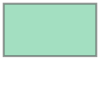

In [ ]:
footprint = None
for i in area_shape['geometry']:
    footprint = i
    
footprint

# Download satellite file corresponding to footprint with Sentinel API

Before we are able to use sentinelsat, we need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

In [ ]:
user = 'cstehle' 
password = 'mdpCopernicus01' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

Run a query for Sentinel-2 images with Level 2A with cloud coverage between 0 and 2 % that fall or intersect with the footprint (Area of study). For the time period, we are interested in Sentinel Level 2A satellite images taken between '20210201' and '20210228' (For reference on valid search queries please refer to [scihub](https://scihub.copernicus.eu/twiki/do/view/SciHubUserGuide/FullTextSearch?redirectedfrom=SciHubUserGuide.3FullTextSearch)).

In [ ]:
# Remark: if we do the search with the area footprint as a polygon or rectangle, 
# we perform a Geographical search of the products 
# whose footprint intersects or is included in the given area footprint.
# products = api.query(footprint,
#                   date = ('20210201', '20210430'),
#                   platformname = 'Sentinel-2',
#                   processinglevel = 'Level-2A',
#                   cloudcoverpercentage = (0,2))

In [ ]:
# To be sure that the whole rectangle that we want is included in the satellite image, 
# we perform 4 searches that include points = the corners of the rectangle of interest
# and we look for the intersection of these searches:
prod = []
for p in area_points_list:
   res = api.query(p,
                     date = ('20210201', '20210430'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,2))
   prod.append(res)

shared_keys = prod[0].keys() & prod[1].keys() & prod[2].keys() & prod[3].keys()
dict_intersection = {k: prod[0][k] for k in shared_keys }
products = dict_intersection

We get a dictionary of all products available in this period with the query specification.

In [ ]:
# Check number of products from the query
if len(products) > 0:
   print("Number of products found: ",len(products))
else:
   print("No products found. Try to rerun the query by changing the parameters (ex: increase cloudcoverpercentage or date window) ")   

Number of products found:  5


From here we can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage.

In [ ]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,ingestiondate,beginposition,endposition,generationdate,orbitnumber,relativeorbitnumber,cloudcoverpercentage,highprobacloudspercentage,mediumprobacloudspercentage,notvegetatedpercentage,snowicepercentage,unclassifiedpercentage,vegetationpercentage,waterpercentage,illuminationazimuthangle,illuminationzenithangle,filename,format,identifier,instrumentshortname,instrumentname,s2datatakeid,platformidentifier,orbitdirection,platformserialidentifier,processingbaseline,processinglevel,producttype,platformname,size,datastripidentifier,granuleidentifier,level1cpdiidentifier,uuid,geometry
80e27637-33c6-4dee-9696-cdb54242e135,S2B_MSIL2A_20210315T102709_N0214_R108_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-03-15T10:27:09.024Z, Instrument: MS...",false,2021-03-17 13:07:11.533,2021-03-15 10:27:09.024,2021-03-15 10:27:09.024,2021-03-15 13:24:13,21012,108,1.040415,0.627241,0.408404,16.925678,7.061622,2.956351,31.502777,34.747839,159.091711,47.724006,S2B_MSIL2A_20210315T102709_N0214_R108_T32TLP_2...,SAFE,S2B_MSIL2A_20210315T102709_N0214_R108_T32TLP_2...,MSI,Multi-Spectral Instrument,GS2B_20210315T102709_021012_N02.14,2017-013A,DESCENDING,Sentinel-2B,02.14,Level-2A,S2MSI2A,Sentinel-2,1.01 GB,S2B_OPER_MSI_L2A_DS_VGS2_20210315T132413_S2021...,S2B_OPER_MSI_L2A_TL_VGS2_20210315T132413_A0210...,S2B_OPER_MSI_L1C_TL_VGS2_20210315T124340_A0210...,80e27637-33c6-4dee-9696-cdb54242e135,"MULTIPOLYGON (((6.53677 43.23826, 7.75962 43.2..."
caeff8f6-c695-438c-8098-e9ae194a0f00,S2B_MSIL2A_20210401T101559_N0300_R065_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-04-01T10:15:59.024Z, Instrument: MS...",false,2021-04-01 19:23:31.231,2021-04-01 10:15:59.024,2021-04-01 10:15:59.024,2021-04-01 14:19:13,21255,65,1.243917,0.806955,0.429254,18.583122,4.247823,2.361299,30.021113,40.637511,154.720924,41.673956,S2B_MSIL2A_20210401T101559_N0300_R065_T32TLP_2...,SAFE,S2B_MSIL2A_20210401T101559_N0300_R065_T32TLP_2...,MSI,Multi-Spectral Instrument,GS2B_20210401T101559_021255_N03.00,2017-013A,DESCENDING,Sentinel-2B,03.00,Level-2A,S2MSI2A,Sentinel-2,865.04 MB,S2B_OPER_MSI_L2A_DS_VGS4_20210401T141913_S2021...,S2B_OPER_MSI_L2A_TL_VGS4_20210401T141913_A0212...,S2B_OPER_MSI_L1C_TL_VGS4_20210401T132244_A0212...,caeff8f6-c695-438c-8098-e9ae194a0f00,"MULTIPOLYGON (((6.53677 43.23826, 7.88868 43.2..."
ed070a99-df61-40c6-8c62-501b8f133ca9,S2A_MSIL2A_20210330T103021_N0300_R108_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-03-30T10:30:21.024Z, Instrument: MS...",false,2021-03-30 19:43:17.146,2021-03-30 10:30:21.024,2021-03-30 10:30:21.024,2021-03-30 15:19:21,30135,108,1.292153,0.823612,0.468266,19.433917,5.332713,2.852229,32.242471,34.747288,158.412217,41.739695,S2A_MSIL2A_20210330T103021_N0300_R108_T32TLP_2...,SAFE,S2A_MSIL2A_20210330T103021_N0300_R108_T32TLP_2...,MSI,Multi-Spectral Instrument,GS2A_20210330T103021_030135_N03.00,2015-028A,DESCENDING,Sentinel-2A,03.00,Level-2A,S2MSI2A,Sentinel-2,1016.87 MB,S2A_OPER_MSI_L2A_DS_VGS2_20210330T151921_S2021...,S2A_OPER_MSI_L2A_TL_VGS2_20210330T151921_A0301...,S2A_OPER_MSI_L1C_TL_VGS2_20210330T142339_A0301...,ed070a99-df61-40c6-8c62-501b8f133ca9,"MULTIPOLYGON (((6.53677 43.23826, 7.76061 43.2..."
47924584-f891-4f6a-a53d-126ff0ee7015,S2B_MSIL2A_20210220T101939_N0214_R065_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-02-20T10:19:39.024Z, Instrument: MS...",false,2021-02-20 22:50:32.048,2021-02-20 10:19:39.024,2021-02-20 10:19:39.024,2021-02-20 13:09:38,20683,65,1.414243,0.935248,0.476673,11

In [ ]:
# A geopandas dataframe is a pandas dataframe with a geometry column
type(products_gdf_sorted)

geopandas.geodataframe.GeoDataFrame

Download image of interest: first image in the list that has less could percentage, and for which download is successful 

In [ ]:
from sat_tools import extractFile

In [ ]:
download_OK = False
product_idx = 0
while not download_OK and (product_idx < len(products)):
  try: # it can happen that the download is incomplete or file is not any more on the sentinel server
    sat_image_uuid = products_gdf_sorted['uuid'][product_idx]
    api.download(sat_image_uuid)
    sat_image_id = products_gdf_sorted['identifier'][product_idx]
    zipfilename = products_gdf_sorted['identifier'][product_idx] + ".zip"
    extractFile(zipfilename, 'Sentinel2_images/') 
    download_OK = True
  except:
    product_idx = product_idx + 1

In [ ]:
if download_OK:
  print("index found:", product_idx )
  print("zipfilename:", zipfilename )
else:
   print("No downloadable product. Try to rerun the Sentinel API query by changing the parameters (ex: increase cloudcoverpercentage or date window) ")     

index found: 3
zipfilename: S2B_MSIL2A_20210220T101939_N0214_R065_T32TLP_20210220T130938.zip


In [ ]:
ls -l *.zip

-rw------- 1 root root    2858922 Apr  3 16:25 espacesverts_paris.zip
-rw------- 1 root root   23598727 Apr  3 16:44 french_departments.zip
-rw------- 1 root root 1203127049 Mar 19 09:13 S2A_MSIL2A_20210225T170251_N0214_R069_T14QNG_20210225T211901.zip
-rw------- 1 root root   17604177 May 24 20:55 S2A_MSIL2A_20210330T103021_N0300_R108_T32TLP_20210330T151921.zip
-rw------- 1 root root  992758927 May 24 09:13 S2B_MSIL2A_20210220T101939_N0214_R065_T32TLP_20210220T130938.zip


# Select 10m bands and create RGB image (RGB.tiff)

In [ ]:
import glob2

In [ ]:
common_path = 'Sentinel2_images/' + sat_image_id + '.SAFE/GRANULE/*/IMG_DATA/'

In [ ]:
#check if the contents of the zip file have been actually extracted
#glob2.glob returns a list of files in a directory
assert len(glob2.glob(common_path + '*')) > 0

Let's work only on 10 bands resolution to start.
We'll deal with different resolution bands later...

In [ ]:
# Open Bands 8, 4, 3 and 2 with Rasterio
R10 = common_path + 'R10m'

b8 = rio.open(glob2.glob(R10+'/*_B08_10m.jp2')[0])
b4 = rio.open(glob2.glob(R10+'/*_B04_10m.jp2')[0])
b3 = rio.open(glob2.glob(R10+'/*_B03_10m.jp2')[0])
b2 = rio.open(glob2.glob(R10+'/*_B02_10m.jp2')[0])

In [ ]:
b4.count, b4.width, b4.height

(1, 10980, 10980)

In [ ]:
# Optional : Create RGB image
with rio.open('RGB_' + area + '.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as dst:
    dst.write(b2.read(1),1) 
    dst.write(b3.read(1),2) 
    dst.write(b4.read(1),3) 
    dst.close()

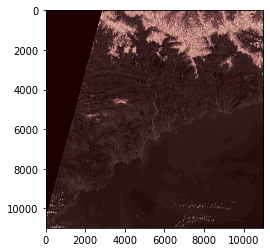

In [ ]:
# Plot first band of RGB image
src = rasterio.open("RGB_" + area + ".tiff")
plt.imshow(src.read(1), cmap='pink')
plt.show()

# Select and upsample 20m bands

In [ ]:
# Open Bands 5, 6 and 7, 8A, 11, 12 with Rasterio
R20 = common_path + 'R20m'

b5 = rio.open(glob2.glob(R20+'/*_B05_20m.jp2')[0])
b6 = rio.open(glob2.glob(R20+'/*_B06_20m.jp2')[0])
b7 = rio.open(glob2.glob(R20+'/*_B07_20m.jp2')[0])
b8A = rio.open(glob2.glob(R20+'/*_B8A_20m.jp2')[0])
b11 = rio.open(glob2.glob(R20+'/*_B11_20m.jp2')[0])
b12 = rio.open(glob2.glob(R20+'/*_B12_20m.jp2')[0])

In [ ]:
b5.count, b5.width, b5.height

(1, 5490, 5490)

20m resolution images are smaller than the 10m resolution images. To run our NN we need images of same size and therefore we need to upsample the 20m resolution images. To be sure to obtain images of same size after croping, we need to resample first, and then apply the mask corresponding to the area of interest (otherwise there can be a difference of 2 pixels)

In [ ]:
from rasterio.enums import Resampling

def resample_image(src, upscale_factor=2):

    # resample data to target shape
    data = src.read(
        out_shape=(
            src.count,
            int(src.height * upscale_factor),
            int(src.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    return [data, transform]


In [ ]:
# Loop to resample 20m bands images
for (band, bandchar) in zip((b5, b6, b7, b8A, b11, b12), ("b5", "b6", "b7", "b8A", "b11", "b12")):
  out_image, out_transform = resample_image(band, upscale_factor=2)
  out_meta = band.meta.copy()
  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
  with rasterio.open(bandchar+"_r.tif", "w", **out_meta) as dest:
    dest.write(out_image)



# Mask Satellite images

In [ ]:
# Check what is the crs of the file to mask
src = rasterio.open("RGB_" + area + ".tiff") 
src_crs = src.crs

CRS.from_epsg(32632)

In [ ]:
print(src.crs)

EPSG:32632


In [ ]:
# Change the projection 
area_shape_proj = area_shape.to_crs({'init': src_crs})
area_shape_proj

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,mixed,geometry
0,polygon1,"POLYGON ((338295.245 4841454.909, 348567.634 4..."


In [ ]:
# Optional: crop RGB image
with rio.open("RGB_" + area + ".tiff") as src:
    out_image, out_transform = rio.mask.mask(src, area_shape_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_" + area + "_masked.tiff", "w", **out_meta) as dest:
    dest.write(out_image)

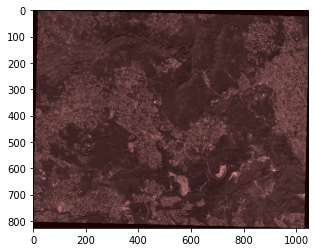

In [ ]:
# Plot first band of RGB image
src = rasterio.open("RGB_" + area + "_masked.tiff")
plt.imshow(src.read(1), cmap='pink')
plt.show()

In [ ]:
# Loop to crop all single bands images for the area
for (band, bandchar) in zip((b2, b3, b4, b8), ("b2", "b3", "b4", "b8")):
  out_image, out_transform = rio.mask.mask(band, area_shape_proj.geometry,crop=True)
  out_meta = band.meta.copy()
  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
  with rasterio.open(area + "_" + bandchar + "_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
# Loop to crop resampled bands images for the area
for bandchar in ("b5_r", "b6_r", "b7_r", "b8A_r", "b11_r", "b12_r"):
  band = rasterio.open(bandchar+".tif")
  out_image, out_transform = rio.mask.mask(band, area_shape_proj.geometry,crop=True)
  out_meta = band.meta.copy()
  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
  with rasterio.open(area + "_" + bandchar + "_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

Comparison of images sizes obtained with 10m resolution (without resampling) and 20 m resolution after resampling : they should be equal

In [ ]:
# 10m band after croping only :
with rio.open(area + '_' + 'b4_masked.tif', 'r') as ds:
    tmp = ds.read()  
print(tmp.shape)

(1, 827, 1047)


In [ ]:
# After resampling then croping:
with rio.open(area + '_' + 'b5_r_masked.tif', 'r') as ds:
    area_b5_r_raster = ds.read()  
print(area_b5_r_raster.shape)

(1, 827, 1047)


# Create multiband image (allbands.tiff) for croped area

In [ ]:
# Create 1 single tiff file with all bands
b2 = rio.open(area + '_' + 'b2_masked.tif')
b3 = rio.open(area + '_' + 'b3_masked.tif')
b4 = rio.open(area + '_' + 'b4_masked.tif')
b5_r = rio.open(area + '_' + 'b5_r_masked.tif')
b6_r = rio.open(area + '_' + 'b6_r_masked.tif')
b7_r = rio.open(area + '_' + 'b7_r_masked.tif')
b8 = rio.open(area + '_' + 'b8_masked.tif')
b8A_r = rio.open(area + '_' + 'b8A_r_masked.tif')
b11_r = rio.open(area + '_' + 'b11_r_masked.tif')
b12_r = rio.open(area + '_' + 'b12_r_masked.tif')

with rio.open(area + '_' + 'allbands.tiff','w',driver='Gtiff', width=b2.width, height=b2.height, 
              count=10,crs=b2.crs,transform=b2.transform, dtype=b2.dtypes[0]) as dst:
    dst.write(b2.read(1),1) 
    dst.write(b3.read(1),2) 
    dst.write(b4.read(1),3) 
    dst.write(b5_r.read(1),4) 
    dst.write(b6_r.read(1),5) 
    dst.write(b7_r.read(1),6) 
    dst.write(b8.read(1),7) 
    dst.write(b8A_r.read(1),8) 
    dst.write(b11_r.read(1),9) 
    dst.write(b12_r.read(1),10) 
    dst.close()


In [ ]:
with rio.open(area + '_' + 'allbands.tiff', 'r') as ds:
    featuresArea = ds.read()  # read all raster values

print(featuresArea.shape)  # this is a 3D numpy array, with dimensions [band, row, col]


(10, 827, 1047)


In [ ]:
# do some cleaning of intermediate tif files 
# and move final tiff files (multiband) in folder Sentinel2_images 

In [ ]:
rm *.tif

In [ ]:
mv *.tiff ./Sentinel2_images/